In [2]:
%load_ext autoreload 
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np 
import nibabel 
from matplotlib.cm import get_cmap
import os.path as op 
from scipy import stats 
from shutil import copytree 
from pathlib import Path 

cmap = np.array(get_cmap('tab10').colors)
loadnii = lambda p: nibabel.load(str(p)).get_fdata()
FIGSIZE = 4

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
niiload = lambda p: nibabel.load(p).get_fdata()
root = '/mnt/hgfs/Data/thesis_data/maastricht_final'

thr = 0.1
SUBJECTS = ['03', '022', '01']
t_regress = np.zeros((len(SUBJECTS), 4, 2))
f_regress = np.zeros_like(t_regress)

for sidx,sub in enumerate(SUBJECTS):
    for rpt in range(1,5):
        for ridx, roi in enumerate(['', 'cortex_']): 
            oxdir = op.join(root, 'processed/oxasl',
                            f'sub-{sub}/sub-{sub}_run-{rpt:02d}_scale-2')
            cbf = niiload(op.join(oxdir, 'output/native/perfusion_calib.nii.gz'))
            fgm = niiload(op.join(root, 'processed/asl',
                                 f'sub-{sub}/sub-{sub}_run-{rpt:02d}_scale-2_pvs/FAST_GM.nii.gz'))

            tgm = niiload(op.join(root, 'processed/asl',
                                 f'sub-{sub}/sub-{sub}_run-{rpt:02d}_scale-2_pvs/{roi}GM.nii.gz'))

            mask = (tgm > thr) & (fgm > thr)
            t_regress[sidx,rpt-1,ridx] = stats.linregress(tgm[mask], cbf[mask]).rvalue
            f_regress[sidx,rpt-1,ridx] = stats.linregress(fgm[mask], cbf[mask]).rvalue
       
extra_t = np.zeros(2)
extra_f = np.zeros(2)
for ridx, roi in enumerate(['', 'cortex_']): 
    oxdir = op.join(root, 'processed/oxasl',
                    f'sub-SS/sub-SS_run-01_scale-2')
    cbf = niiload(op.join(oxdir, 'output/native/perfusion_calib.nii.gz'))
    fgm = niiload(op.join(root, 'processed/asl',
                         f'sub-SS/sub-SS_run-01_scale-2_pvs/FAST_GM.nii.gz'))

    tgm = niiload(op.join(root, 'processed/asl',
                         f'sub-SS/sub-SS_run-01_scale-2_pvs/{roi}GM.nii.gz'))

    mask = (tgm > thr) & (fgm > thr)
    extra_t[ridx] = stats.linregress(tgm[mask], cbf[mask]).rvalue
    extra_f[ridx] = stats.linregress(fgm[mask], cbf[mask]).rvalue

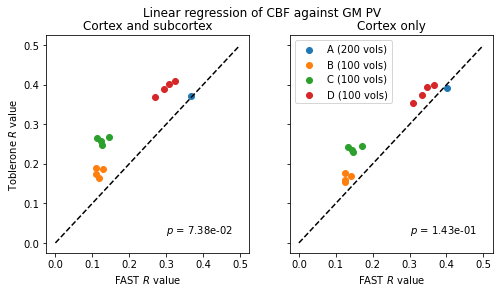

In [4]:
fig, axes = plt.subplots(1,2, sharey=True, figsize=(8,4))

for idx,(ax,title) in enumerate(zip(axes, ['Cortex and subcortex', 'Cortex only'])):

    ax.plot([0,0.5], [0,0.5], 'k--')
    ax.scatter(x=extra_f[idx], y=extra_t[idx], label='A (200 vols)')
    ax.set_title(title)
    ax.set_xlabel(r'FAST $R$ value')
    for sidx,sub in enumerate(['B','C','D']):
        ax.scatter(x=f_regress[sidx,:,idx], y=t_regress[sidx,:,idx], label=f'{sub} (100 vols)')
        
    t = [ *t_regress[:,:,idx].mean(1).flatten(), extra_t[idx] ]
    f = [ *f_regress[:,:,idx].mean(1).flatten(), extra_f[idx] ]
    ttest = stats.ttest_rel(t, f)
    ax.text(0.30, 0.025, fr'$p$ = {ttest.pvalue:0.2e}')

fig.suptitle('Linear regression of CBF against GM PV')
axes[0].set_ylabel(r'Toblerone $R$ value')
ax.legend()
plt.savefig('figs/tob_vs_fast_cbf_correlation.png', dpi=250, bbox_inches='tight')
plt.show()